In [1]:
import os, sys
sys.path.insert(0, os.path.join(os.getenv('HOME'), 'StarNet'))
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import fits as pyfits

from starnet.utils.data_utils.augment import convolve_spectrum
from starnet.utils.data_utils.restructure_spectrum import rebin, continuum_normalize, ensure_constant_sampling

/home/nrpu88/jupyter_py3/lib/python3.6/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/home/nrpu88/jupyter_py3/lib/python3.6/site-packages/pysynphot/locations.py:329: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/home/nrpu88/jupyter_py3/lib/python3.6/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for ftp://ftp.stsci.edu/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/home/nrpu88/jupyter_py3/lib/python3.6/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for ftp://ftp.stsci.edu/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


In [2]:
# Define parameters needed for continuum fitting
LINE_REGIONS = [[4210, 4240], [4250, 4410], [4333, 4388], [4845, 4886], [5160, 5200], [5874, 5916], [6530, 6590]]
SEGMENTS_STEP = 10.  # divide the spectrum into segments of 10 Angstroms

In [3]:
home = os.getenv('HOME')
scratch = os.getenv('SCRATCH')
starnet_data_folder = os.path.join(home, 'StarNet/starnet/data/')
intrigoss_grid_path = os.path.join(home, 'projects/rrg-kyi/group_writable/spectra/grids/intrigoss') 
phoenix_grid_path = os.path.join(home, 'projects/rrg-kyi/group_writable/spectra/grids/phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/') 
ambre_grid_path = os.path.join(home, 'projects/rrg-kyi/group_writable/spectra/grids/AMBRE/train')
obs_wave_filepath = os.path.join(home, 'projects/rrg-kyi/group_writable/spectra/UVES_4835-5395.npy')
wave_grid_obs = np.load(obs_wave_filepath)

### Create functions for loading Phoenix and INTRIGOSS spectra

#### Phoenix...

In [4]:
def get_phoenix_filename(teff, logg, feh, afe):
    """
    This function returns the name of the Phoenix spectrum file with the requested stellar parameters.
    
    INPUT: teff: Effective temperature (K)
           logg: Surface gravity
           feh: Metallicity (dex)
           afe: Alpha elements abundance [alpha/Fe]

    RETURNS: filename: Name of the .fits file containing an INTRIGOSS spectrum
    EXAMPLE: With input of teff=4000, logg=1.0, feh=-1.0, afe=0.5, it returns the string
             'lte04000-1.00-1.0.Alpha=+0.50.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'
    """
        
    str_teff = 'lte{:05d}'.format(teff)
    str_logg = '-{:03.2f}'.format(logg)
    str_feh = '{:02.1f}'.format(feh)
    if feh>0: 
        str_feh = '+' + str_feh
        
    if afe == 0:
        str_afe = ''
    elif afe < 0:
        str_afe = '.Alpha={:03.2f}'.format(afe)
    elif afe > 0:
        str_afe = '.Alpha=+{:03.2f}'.format(afe)

    filename = '{}{}{}{}.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'.format(str_teff, str_logg, str_feh, str_afe)

    return filename

def find_closest_phoenix_match(teff, logg, feh, afe):
    
    """
    Given a set of stellar parameters, this function will return the stellar parameters from the Phoenix
    grid which are closest to the supplied parameters.
    
    INPUT: teff: Effective temperature (K)
           logg: Surface gravity
           feh: Metallicity (dex)
           afe: Alpha elements abundance [alpha/Fe]

    RETURNS: Closest matching stellar parameters from the Phoenix grid
    EXAMPLE: With input of teff=3900, logg=1.1, feh=-1.1, afe=0.6, it returns 4 values:
             3900, 1.0, -1.0, 0.5
    """

    # Phoenix spectra grid spacing
    teff_grid = np.arange(2300,7000,100)
    teff_grid = np.concatenate((teff_grid, np.arange(7000,12001,200)))
    logg_grid = np.arange(0, 6.1, 0.5)
    feh_grid = np.arange(-4., -2.0, 1)
    feh_grid = np.concatenate((feh_grid, np.arange(-2.0, 1.01, 0.5)))
    afe_grid = np.arange(-0.2, 1.21, 0.2)

    # Find closest parameter values
    match_teff = teff_grid[np.argmin(np.abs(teff - teff_grid))]
    match_logg = logg_grid[np.argmin(np.abs(logg - logg_grid))]
    match_feh = feh_grid[np.argmin(np.abs(feh - feh_grid))]
    match_afe = afe_grid[np.argmin(np.abs(afe - afe_grid))]
    
    match_afe = round(match_afe,2)
    
    return match_teff, match_logg, match_feh, match_afe

def get_phoenix_spectrum(spectrum_path, wave_grid_path):
    
    """
    Given the path of a Phoenix spectrum .fits file, this function retrieves the flux and wavelength data
    
    INPUT: path: The path to the Phoenix spectrum file, e.g. '/path/to/lte04000-1.00-1.0.Alpha=+0.50.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'
    
    RETURNS: wav: wavelength data
             flux: flux data
    """
    
    hdulist_spectrum = pyfits.open(spectrum_path)
    hdulist_wavegrid = pyfits.open(wave_grid_path)
    
    flux = hdulist_spectrum[0].data
    wav = hdulist_wavegrid[0].data
    
    # For Phoenix, need to convert from vacuum to air wavelengths.
    # The IAU standard for conversion from air to vacuum wavelengths is given
    # in Morton (1991, ApJS, 77, 119). For vacuum wavelengths (VAC) in
    # Angstroms, convert to air wavelength (AIR) via:
    #  AIR = VAC / (1.0 + 2.735182E-4 + 131.4182 / VAC^2 + 2.76249E8 / VAC^4)
    wav = wav / (
            1.0 + 2.735182E-4 + 131.4182 / wav ** 2 + 2.76249E8 / wav ** 4)
    
    return wav, flux

#### INTRIGOSS...

In [5]:
def get_intrigoss_filename(teff, logg, feh, afe):
    
    """
    This function returns the name of the INTRIGOSS spectrum file with the requested stellar parameters.
    
    INPUT: teff: Effective temperature (K)
           logg: Surface gravity
           feh: Metallicity (dex)
           afe: Alpha elements abundance [alpha/Fe]

    RETURNS: filename: Name of the .fits file containing an INTRIGOSS spectrum
    EXAMPLE: With input of teff=4000, logg=1.0, feh=-1.0, afe=0.5, it returns the string
             'alpp050_am100_t4000g10_v1_f.fits'
    """
    
    # Construct the full INTRIGOSS .fits file name from stellar parameters
    if feh>0.:
        str_feh= 'ap{}{}'.format(int(feh),('%.2f' % (feh % 1))[2:4])
    elif feh<0.:
        str_feh= 'am{}{}'.format(int(-feh),('%.2f' % (-feh % 1))[2:4])
    else:
        str_feh= 'ap000'
    if afe>0.:
        str_afe= 'alpp{}{}'.format(int(afe),('%.2f' % (afe % 1))[2:4])
    elif afe<0.:
        str_afe= 'alpm{}{}'.format(int(-afe),('%.2f' % (-afe % 1))[2:4])
    else:
        str_afe= 'alpp000'
    str_logg = 'g%i%i' % (int(logg),int(round((logg % 1)*10.)))
    filename = '{}_{}_t{}{}_v1_f.fits'.format(str_afe, str_feh, teff, str_logg)
    
    return filename

def find_closest_intrigoss_match(teff, logg, feh, afe):
    
    """
    Given a set of stellar parameters, this function will return the stellar parameters from the INTRIGOSS
    grid which are closest to the supplied parameters.
    
    INPUT: teff: Effective temperature (K)
           logg: Surface gravity
           feh: Metallicity (dex)
           afe: Alpha elements abundance [alpha/Fe]

    RETURNS: Closest matching stellar parameters from the INTRIGOSS grid
    EXAMPLE: With input of teff=3900, logg=1.1, feh=-1.1, afe=0.6, it returns 4 values:
             4000, 1.0, -1.0, 0.5
    """
    
    # INTRIGOSS grid spacing
    teff_grid = np.arange(3750, 7001, 250)
    logg_grid = np.arange(0.5, 5.1, 0.5)
    feh_grid = np.arange(-1.0, 0.51, 0.25)
    afe_grid = np.arange(-0.25, 0.51, 0.25) 
    
    # Find closest parameter values
    match_teff = teff_grid[np.argmin(np.abs(teff - teff_grid))]
    match_logg = logg_grid[np.argmin(np.abs(logg - logg_grid))]
    match_feh = feh_grid[np.argmin(np.abs(feh - feh_grid))]
    match_afe = afe_grid[np.argmin(np.abs(afe - afe_grid))]
    
    return match_teff, match_logg, match_feh, match_afe

def get_intrigoss_spectrum(path):
    
    """
    Given the path of an INTRIGOSS spectrum .fits file, this function retrieves the flux and wavelength data
    
    INPUT: path: The path to the INTRIGOSS spectrum file, e.g. '/path/to/alpp050_am100_t4000g10_v1_f.fits'
    
    RETURNS: wav: wavelength data
             flux: flux data
    """
    
    hdulist = pyfits.open(path)
    flux_data = hdulist[1].data
    
    wav = flux_data['wavelength']
    flux = flux_data['surface_flux']
    
    return wav, flux

In [6]:
def get_ambre_filename(teff, logg, feh, afe):
    
    """
    This function returns the name of the AMBRE spectrum file with the requested stellar parameters.
    
    INPUT: teff: Effective temperature (K)
           logg: Surface gravity
           feh: Metallicity (dex)
           afe: Alpha elements abundance [alpha/Fe]

    RETURNS: filename: Name of the .fits file containing an AMBRE spectrum
    EXAMPLE: With input of teff=4000, logg=1.0, feh=-1.0, afe=0.5, it returns the string
             'alpp050_am100_t4000g10_v1_f.AMBRE'
    """
    
    # Construct the full AMBRE .fits file name from stellar parameters
    for root, dirs, files in os.walk(ambre_grid_path):
        for filename in files:
            if teff == float(filename[1:5]):
                if filename[7] == '-':
                    if logg == -1*float(filename[8:11]):
                        if filename[22] == '-':
                            if feh == -1*float(filename[23:27]):
                                if filename[29] == '-':
                                    if afe == -1*float(filename[30:34]):
                                        filename_fin = filename
                                elif afe == float(filename[30:34]):
                                    filename_fin = filename
                                    
                        elif feh == float(filename[23:27]):
                            if filename[29] == '-':
                                if afe == -1*float(filename[30:34]):
                                    filename_fin = filename
                            elif afe == float(filename[30:34]):
                                filename_fin = filename
    
                        
                elif logg == float(filename[8:11]):
                    if filename[22] == '-':
                        if feh == -1*float(filename[23:27]):
                            if filename[29] == '-':
                                if afe == -1*float(filename[30:34]):
                                    filename_fin = filename
                            elif afe == float(filename[30:34]):
                                    filename_fin = filename
                                    
                    elif feh == float(filename[23:27]):
                        if afe == -1*float(filename[30:34]):
                            filename_fin = filename
                        elif afe == float(filename[30:34]):
                            filename_fin = filename
    
    
        
    return filename_fin


def find_closest_ambre_match(teff, logg, feh, afe):
    
    """
    Given a set of stellar parameters, this function will return the stellar parameters from the AMBRE
    grid which are closest to the supplied parameters.
    
    INPUT: teff: Effective temperature (K)
           logg: Surface gravity
           feh: Metallicity (dex)
           afe: Alpha elements abundance [alpha/Fe]

    RETURNS: Closest matching stellar parameters from the AMBRE grid
    EXAMPLE: With input of teff=3900, logg=1.1, feh=-1.1, afe=0.6, it returns 4 values:
             4000, 1.0, -1.0, 0.5
    """
    
        # AMBRE grid spacing
    if teff <= 3900:
        teff_grid = np.arange(2500, 4000, 200)
    elif teff >= 4000:
        teff_grid = np.arange(4000, 8500, 250)
    logg_grid = np.arange(-0.5, 6, 0.5)
    if feh >= -1.0:
        feh_grid = np.arange(-1.5, 1.5, 0.25)
    elif feh >= -3.0 and feh < -1.0:
        feh_grid = np.arange(-3.5,-1.0, 0.5)
    elif feh < -3.0:
        feh_grid = np.arange(-5.0,-3.0, 1.0)
    afe_grid = np.arange(-0.40, 1.00, 0.20) 
    
    
    # Find closest parameter values
    match_teff = teff_grid[np.argmin(np.abs(teff - teff_grid))]
    match_logg = logg_grid[np.argmin(np.abs(logg - logg_grid))]
    match_feh = feh_grid[np.argmin(np.abs(feh - feh_grid))]
    match_afe = afe_grid[np.argmin(np.abs(afe - afe_grid))]
    
    match_afe = round(match_afe,2)
    match_logg = round(match_logg,2)
    match_feh = round(match_feh,2)
    
    return match_teff, match_logg, match_feh, match_afe

def get_ambre_spectrum(path):
    
    """
    Given the path of an AMBRE spectrum .fits file, this function retrieves the flux and wavelength data
    
    INPUT: path: The path to the AMBRE spectrum file, e.g. '/path/to/alpp050_am100_t4000g10_v1_f.AMBRE'
    
    RETURNS: wav: wavelength data
             flux: flux data
    """
    flux = np.genfromtxt(path,usecols=-1)
    wav = np.genfromtxt(path,usecols= 0)
    
    return wav, flux

### Define requested stellar parameters

### Load in the spectra, degrade resolution, rebin to UVES, and then continuum normalize

In [7]:
def preprocess(t,l,f,a):

    teff = t
    logg = l
    feh = f
    a_m = a
# Find the closest match in the INTRIGOSS grid for requested parameters
    match_teff_intrigoss, match_logg_intrigoss, \
    match_feh_intrigoss, match_afe_intrigoss = find_closest_intrigoss_match(teff, logg, feh, a_m)

# Find the closest match in the Phoenix grid for requested parameters
    match_teff_phoenix, match_logg_phoenix, \
    match_feh_phoenix, match_afe_phoenix = find_closest_phoenix_match(teff, logg, feh, a_m)

# Find the closest match in the Ambre grid for requested parameters
    match_teff_ambre, match_logg_ambre, \
    match_feh_ambre, match_afe_ambre = find_closest_ambre_match(teff, logg, feh, a_m)


# Construct full string for the INTRIGOSS .fits files
    spec_filename_intrigoss = get_intrigoss_filename(match_teff_intrigoss, 
                                                     match_logg_intrigoss, 
                                                     match_feh_intrigoss,
                                                     match_afe_intrigoss)
    spec_filename_phoenix = get_phoenix_filename(match_teff_phoenix,
                                                 match_logg_phoenix,
                                                 match_feh_phoenix,
                                                 match_afe_phoenix)
    spec_filename_ambre = get_ambre_filename(match_teff_ambre,
                                                 match_logg_ambre,
                                                 match_feh_ambre,
                                                 match_afe_ambre)

    print('INTRIGOSS: Teff: {:d}, logg: {:3.2f}, [Fe/H]: {:3.2f}, [alpha/M]: {:3.2f}'.format(match_teff_intrigoss, 
                                                                                             match_logg_intrigoss,
                                                                                             match_feh_intrigoss, 
                                                                                             match_afe_intrigoss))
    print(spec_filename_intrigoss)

    print('Phoenix:   Teff: {:d}, logg: {:3.2f}, [Fe/H]: {:3.2f}, [alpha/M]: {:3.2f}'.format(match_teff_phoenix, 
                                                                                             match_logg_phoenix,
                                                                                             match_feh_phoenix, 
                                                                                             match_afe_phoenix))
    print(spec_filename_phoenix)

    print('Ambre:   Teff: {:d}, logg: {:3.2f}, [Fe/H]: {:3.2f}, [alpha/M]: {:3.2f}'.format(match_teff_ambre, 
                                                                                             match_logg_ambre,
                                                                                             match_feh_ambre, 
                                                                                             match_afe_ambre))
    print(spec_filename_ambre)

    # Collect INTRIGOSS spectrum
    for root, dirs, files in os.walk(intrigoss_grid_path):
        for name in files:
            if name == spec_filename_intrigoss:
                spec_filepath_intrigoss = os.path.join(root, name)
    wav_intrigoss, flux_intrigoss = get_intrigoss_spectrum(spec_filepath_intrigoss)

    # Collect Phoenix spectrum
    for root, dirs, files in os.walk(phoenix_grid_path):
        for name in files:
            if name == spec_filename_phoenix:
                spec_filepath_phoenix = os.path.join(root, name)
    wavegrid_path = os.path.join(phoenix_grid_path, 'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')
    wav_phoenix, flux_phoenix = get_phoenix_spectrum(spec_filepath_phoenix, wavegrid_path)

    # Collect AMBRE spectrum
    for root, dirs, files in os.walk(ambre_grid_path):
        for name in files:
            if name == spec_filename_ambre:
                spec_filepath_ambre = os.path.join(root, name)
    wav_ambre, flux_ambre = get_ambre_spectrum(spec_filepath_ambre)
    #print(wav_ambre)
    #print(flux_ambre)

    # Trim the wavelength and flux arrays according to observed wave grid
    extension = 10  # Angstroms
    wave_min_request = wave_grid_obs[0] - extension
    wave_max_request = wave_grid_obs[-1] + extension
    wave_indices_intrigoss = (wav_intrigoss > wave_min_request) & (wav_intrigoss < wave_max_request)
    wave_indices_phoenix = (wav_phoenix > wave_min_request) & (wav_phoenix < wave_max_request)
    wave_indices_ambre = (wav_ambre > wave_min_request) & (wav_ambre < wave_max_request)
    wav_intrigoss = wav_intrigoss[wave_indices_intrigoss]
    wav_phoenix = wav_phoenix[wave_indices_phoenix]
    wav_ambre = wav_ambre[wave_indices_ambre]
    flux_intrigoss = flux_intrigoss[wave_indices_intrigoss]
    flux_phoenix = flux_phoenix[wave_indices_phoenix]
    flux_ambre = flux_ambre[wave_indices_ambre]

    # Degrade resolution
    err_intrigoss = np.zeros(len(flux_intrigoss))
    err_phoenix = np.zeros(len(flux_phoenix))
    err_ambre = np.zeros(len(flux_ambre))
    _, flux_intrigoss, _ = convolve_spectrum(wav_intrigoss, flux_intrigoss, err_intrigoss, to_resolution=47000)
    _, flux_phoenix, _ = convolve_spectrum(wav_phoenix, flux_phoenix, err_phoenix, to_resolution=47000)
    _, flux_ambre, _ = convolve_spectrum(wav_ambre, flux_ambre, err_ambre, to_resolution=47000)

    # Rebin to UVES wave grid
    flux_intrigoss = rebin(wave_grid_obs, wav_intrigoss, flux_intrigoss)
    flux_phoenix = rebin(wave_grid_obs, wav_phoenix, flux_phoenix)
    flux_ambre = rebin(wave_grid_obs, wav_ambre, flux_ambre)

    # Continuum normalize the spectra
    flux_intrigoss, _ = continuum_normalize(flux_intrigoss, LINE_REGIONS, wave_grid_obs, SEGMENTS_STEP)
    flux_phoenix, _ = continuum_normalize(flux_phoenix, LINE_REGIONS, wave_grid_obs, SEGMENTS_STEP)
    flux_ambre, _ = continuum_normalize(flux_ambre, LINE_REGIONS, wave_grid_obs, SEGMENTS_STEP)

    print('DONE')
    
    return flux_intrigoss,flux_phoenix,flux_ambre

    # Mask telluric lines
    #flux_intrigoss = mask_tellurics('telluric_lines.txt', flux_intrigoss, wave_grid_obs
    #flux_phoenix = mask_tellurics('telluric_lines.txt', flux_phoenix, wave_grid_obs)
    #flux_ambre = mask_tellurics('telluric_lines.txt', flux_ambre, wave_grid_obs)

In [8]:
stellar_diff = [[5000,2,0.3,0],[4500,2,0.4,0],[4900,3,1,0],[4600,1.5,0.4,0],[4300,2.5,0.4,0]]


In [9]:
flux_diff = []
for i in stellar_diff:
    t = i[0]
    l = i[1]
    f = i[2]
    m = i[3]
    flux_diff.append(preprocess(t,l,f,m))

INTRIGOSS: Teff: 5000, logg: 2.00, [Fe/H]: 0.25, [alpha/M]: 0.00
alpp000_ap025_t5000g20_v1_f.fits
Phoenix:   Teff: 5000, logg: 2.00, [Fe/H]: 0.50, [alpha/M]: 0.00
lte05000-2.00+0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
Ambre:   Teff: 5000, logg: 2.00, [Fe/H]: 0.25, [alpha/M]: 0.00
s5000:g+2.0:m1.0:t02:z+0.25:a+0.00.AMBRE


/home/nrpu88/jupyter_py3/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:165: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/home/nrpu88/jupyter_py3/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:166: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value


DONE
INTRIGOSS: Teff: 4500, logg: 2.00, [Fe/H]: 0.50, [alpha/M]: 0.00
alpp000_ap050_t4500g20_v1_f.fits
Phoenix:   Teff: 4500, logg: 2.00, [Fe/H]: 0.50, [alpha/M]: 0.00
lte04500-2.00+0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
Ambre:   Teff: 4500, logg: 2.00, [Fe/H]: 0.50, [alpha/M]: 0.00
s4500:g+2.0:m1.0:t02:z+0.50:a+0.00.AMBRE
DONE
INTRIGOSS: Teff: 5000, logg: 3.00, [Fe/H]: 0.50, [alpha/M]: 0.00
alpp000_ap050_t5000g30_v1_f.fits
Phoenix:   Teff: 4900, logg: 3.00, [Fe/H]: 1.00, [alpha/M]: 0.00
lte04900-3.00+1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
Ambre:   Teff: 5000, logg: 3.00, [Fe/H]: 1.00, [alpha/M]: 0.00
s5000:g+3.0:m1.0:t02:z+1.00:a+0.00.AMBRE
DONE
INTRIGOSS: Teff: 4500, logg: 1.50, [Fe/H]: 0.50, [alpha/M]: 0.00
alpp000_ap050_t4500g15_v1_f.fits
Phoenix:   Teff: 4600, logg: 1.50, [Fe/H]: 0.50, [alpha/M]: 0.00
lte04600-1.50+0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
Ambre:   Teff: 4500, logg: 1.50, [Fe/H]: 0.50, [alpha/M]: 0.00
s4500:g+1.5:m1.0:t02:z+0.50:a+0.00.AMBRE
DONE
INTRIGOS

In [10]:
flux_diff = np.asarray(flux_diff)
print(flux_diff.shape)

(5, 3, 39436)


In [159]:
flux_sim = []
stellar_sim = [[5350,2,-0.5,0],[5750,3.9,-1,0],[5800,3,-0.5,0],[6000,3,-0.5,0],[5500,3,-0.5,0]]

for i in stellar_sim:
    t = i[0]
    l = i[1]
    f = i[2]
    m = i[3]
    flux_sim.append(preprocess(t,l,f,m))

print(len(flux_sim))

INTRIGOSS: Teff: 5250, logg: 2.00, [Fe/H]: -0.50, [alpha/M]: 0.00
alpp000_am050_t5250g20_v1_f.fits
Phoenix:   Teff: 5300, logg: 2.00, [Fe/H]: -0.50, [alpha/M]: 0.00
lte05300-2.00-0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
Ambre:   Teff: 5250, logg: 2.00, [Fe/H]: -0.50, [alpha/M]: 0.00
s5250:g+2.0:m1.0:t02:z-0.50:a+0.00.AMBRE
DONE
INTRIGOSS: Teff: 5750, logg: 4.00, [Fe/H]: -1.00, [alpha/M]: 0.00
alpp000_am100_t5750g40_v1_f.fits
Phoenix:   Teff: 5700, logg: 4.00, [Fe/H]: -1.00, [alpha/M]: 0.00
lte05700-4.00-1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
Ambre:   Teff: 5750, logg: 4.00, [Fe/H]: -1.00, [alpha/M]: 0.00
p5750:g+4.0:m0.0:t01:z-1.00:a+0.00.AMBRE
DONE
INTRIGOSS: Teff: 5750, logg: 3.00, [Fe/H]: -0.50, [alpha/M]: 0.00
alpp000_am050_t5750g30_v1_f.fits
Phoenix:   Teff: 5800, logg: 3.00, [Fe/H]: -0.50, [alpha/M]: 0.00
lte05800-3.00-0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
Ambre:   Teff: 5750, logg: 3.00, [Fe/H]: -0.50, [alpha/M]: 0.00
s5750:g+3.0:m1.0:t02:z-0.50:a+0.00.AMBRE
DONE
INTR

In [160]:
flux_sim = np.asarray(flux_sim)
print(flux_sim.shape)

(5, 3, 39436)


### Plot spectra

In [161]:
%matplotlib inline

def plotspectra(flux_intrigoss,flux_phoenix,flux_ambre):

    min_wav_plot = 5240
    max_wav_plot = 5260
    indices = (wave_grid_obs > min_wav_plot) & (wave_grid_obs < max_wav_plot)

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(wave_grid_obs[indices], flux_intrigoss[indices], label='INTRIGOSS', alpha=0.6)
    ax.plot(wave_grid_obs[indices], flux_phoenix[indices], label='Phoenix', alpha=0.6)
    ax.plot(wave_grid_obs[indices], flux_ambre[indices], label='Ambre', alpha=0.6)
    ax.legend(loc=0)
    ax.set_xlabel('Wavelength (A)')
    plt.grid()
"""
    print('INTRIGOSS: Teff: {:d}, logg: {:3.2f}, [Fe/H]: {:3.2f}, [alpha/M]: {:3.2f}'.format(match_teff_intrigoss, 
                                                                                             match_logg_intrigoss,
                                                                                             match_feh_intrigoss, 
                                                                                             match_afe_intrigoss))
    print('Phoenix:   Teff: {:d}, logg: {:3.2f}, [Fe/H]: {:3.2f}, [alpha/M]: {:3.2f}'.format(match_teff_phoenix, 
                                                                                             match_logg_phoenix,
                                                                                             match_feh_phoenix, 
                                                                                             match_afe_phoenix))
    print('Ambre:   Teff: {:d}, logg: {:3.2f}, [Fe/H]: {:3.2f}, [alpha/M]: {:3.2f}'.format(match_teff_ambre, 
                                                                                             match_logg_ambre,
                                                                                            match_feh_ambre, 
                                                                                             match_afe_ambre))
"""

"\n    print('INTRIGOSS: Teff: {:d}, logg: {:3.2f}, [Fe/H]: {:3.2f}, [alpha/M]: {:3.2f}'.format(match_teff_intrigoss, \n                                                                                             match_logg_intrigoss,\n                                                                                             match_feh_intrigoss, \n                                                                                             match_afe_intrigoss))\n    print('Phoenix:   Teff: {:d}, logg: {:3.2f}, [Fe/H]: {:3.2f}, [alpha/M]: {:3.2f}'.format(match_teff_phoenix, \n                                                                                             match_logg_phoenix,\n                                                                                             match_feh_phoenix, \n                                                                                             match_afe_phoenix))\n    print('Ambre:   Teff: {:d}, logg: {:3.2f}, [Fe/H]: {:3.2f}, [alpha/M]: 

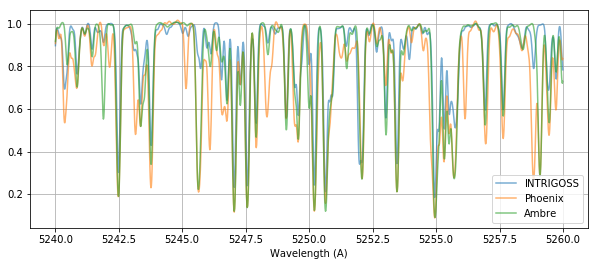

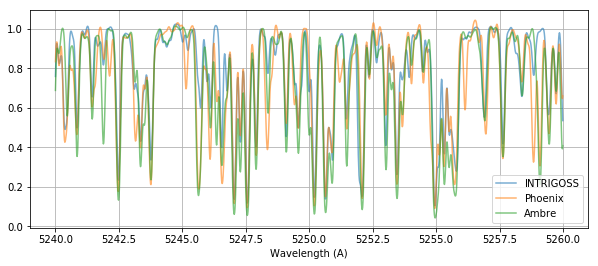

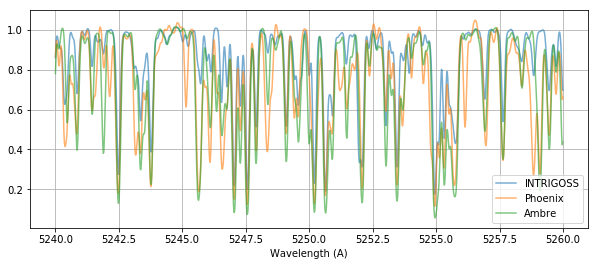

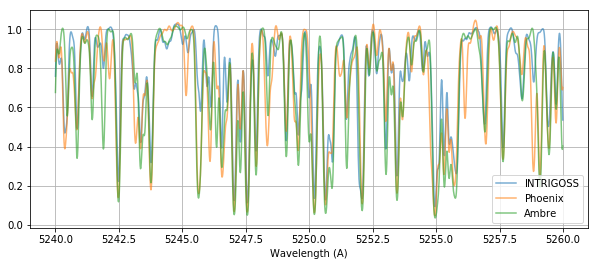

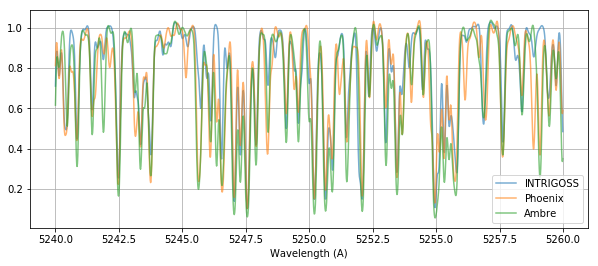

In [162]:
flux_i_diff = []
flux_p_diff = []
flux_a_diff = []


for i in flux_diff:
    flux_i_diff.append(i[0])
    flux_p_diff.append(i[1])
    flux_a_diff.append(i[2])
    
for j in flux_diff:
    plotspectra(j[0],j[1],j[2])

        

In [163]:
flux_i_diff = np.asarray(flux_i_diff)
print(flux_i_diff.shape)

(5, 39436)


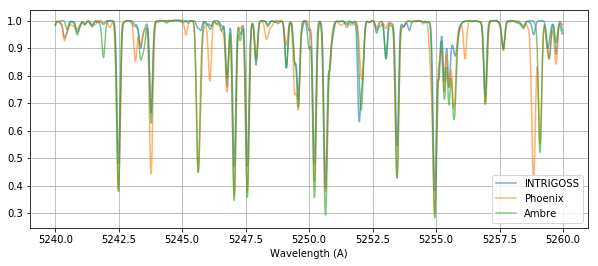

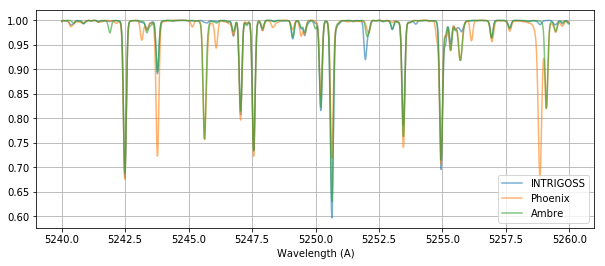

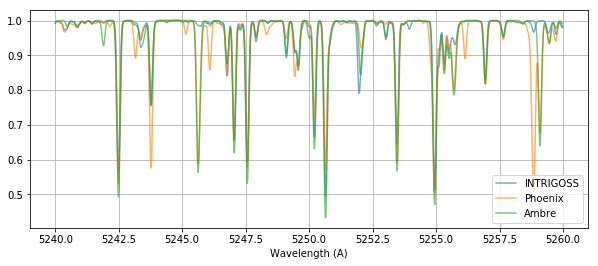

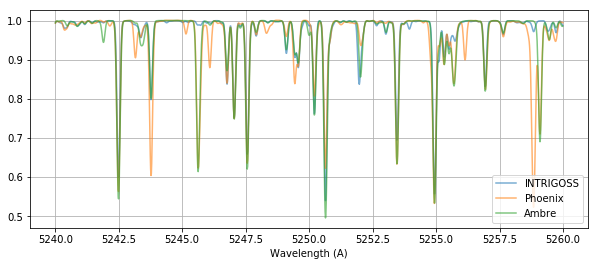

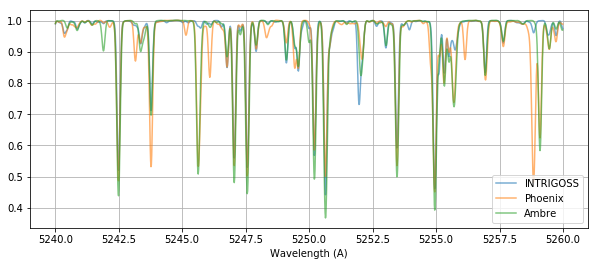

In [164]:
flux_i_sim = []
flux_p_sim = []
flux_a_sim = []


for i in flux_sim:
    flux_i_sim.append(i[0])
    flux_p_sim.append(i[1])
    flux_a_sim.append(i[2])
    
for j in flux_sim:
    plotspectra(j[0],j[1],j[2])

In [165]:
import umap
from openTSNE import TSNE
from openTSNE.callbacks import ErrorLogger



In [166]:
grid_data_diff = []
for i in flux_i_diff:
    grid_data_diff.append(i)
for j in flux_p_diff:
    grid_data_diff.append(j)
for k in flux_a_diff:
    grid_data_diff.append(k)

grid_data_diff = np.asarray(grid_data_diff)
print(grid_data_diff.shape)

(15, 39436)


In [167]:
grid_data_sim = []
for i in flux_i_sim:
    grid_data_sim.append(i)
for j in flux_p_sim:
    grid_data_sim.append(j)
for k in flux_a_sim:
    grid_data_sim.append(k)

grid_data_sim = np.asarray(grid_data_sim)
print(grid_data_sim.shape)

(15, 39436)


In [179]:
tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    callbacks=ErrorLogger(),
    n_jobs=8,
    random_state=42,
)

In [182]:
reducer = umap.UMAP(init = 'random')
embedding_diff = reducer.fit_transform(grid_data_diff)
embedding_sim = reducer.fit_transform(grid_data_sim)

/home/nrpu88/jupyter_py3/lib/python3.6/site-packages/umap/umap_.py:1364: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "
/home/nrpu88/jupyter_py3/lib/python3.6/site-packages/umap/umap_.py:1364: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


In [184]:

%time embedding_diff_tsne = tsne.fit(grid_data_diff)

Perplexity value 30 is too high. Using perplexity 4.67 instead


AttributeError: 'NoneType' object has no attribute 'shape'

In [183]:
%time embedding_sim_tsne = tsne.fit(grid_data_sim)

Perplexity value 30 is too high. Using perplexity 4.67 instead


AttributeError: 'NoneType' object has no attribute 'shape'

Perplexity value 30 is too high. Using perplexity 4.67 instead


AttributeError: 'NoneType' object has no attribute 'shape'

In [172]:
grid_target_diff=[]
for i in range(len(flux_i_diff)):
    grid_target_diff.append(0)
for j in range(len(flux_p_diff)):
    grid_target_diff.append(1)
for k in range(len(flux_a_diff)):
    grid_target_diff.append(2)

In [173]:
grid_target_sim=[]
for i in range(len(flux_i_sim)):
    grid_target_sim.append(0)
for j in range(len(flux_p_sim)):
    grid_target_sim.append(1)
for k in range(len(flux_a_sim)):
    grid_target_sim.append(2)

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns

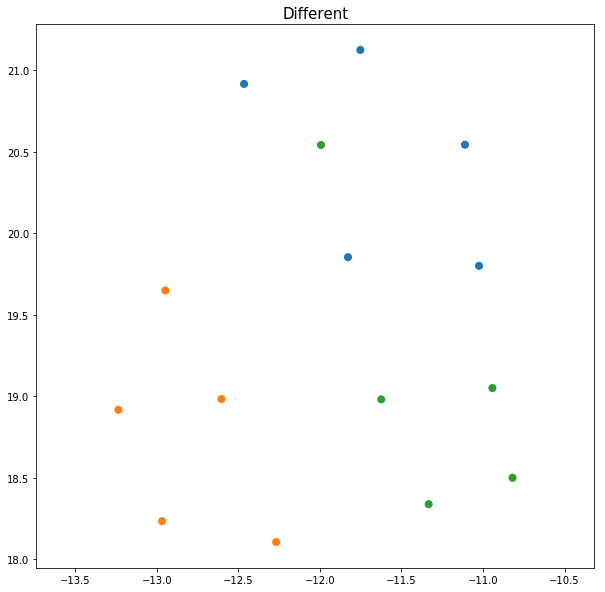

In [175]:
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(embedding_diff[:, 0], embedding_diff[:, 1], c=[sns.color_palette()[x] for x in grid_target_diff],s = 50)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Different', fontsize=15);
#plt.savefig('umap_params_goss.png')

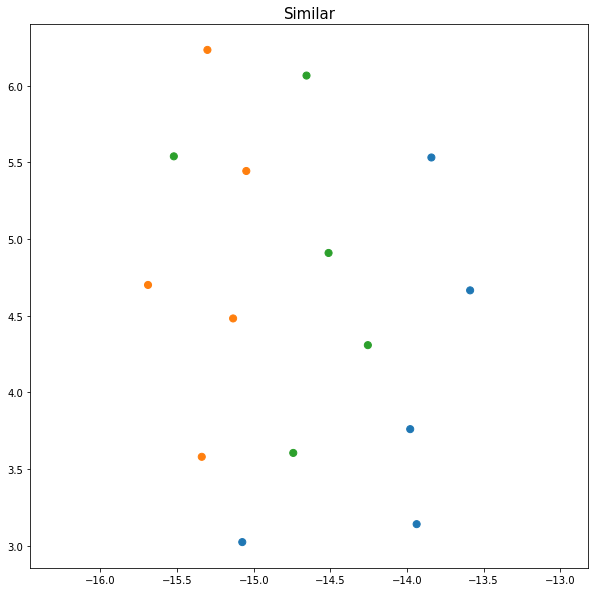

In [177]:
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(embedding_sim[:, 0], embedding_sim[:, 1], c=[sns.color_palette()[x] for x in grid_target_sim],s = 50)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Similar', fontsize=15);
#plt.savefig('umap_params_goss.png')

NameError: name 'embedding_sim_tsne' is not defined

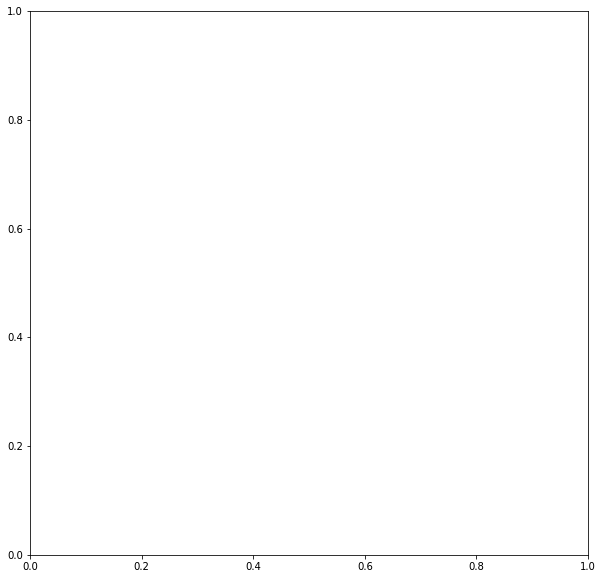

In [128]:
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(embedding_sim_tsne[:, 0], embedding_sim_tsne[:, 1], c=[sns.color_palette()[x] for x in grid_target_sim],s = 50)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Similar', fontsize=15);

NameError: name 'embedding_sim_tsne' is not defined

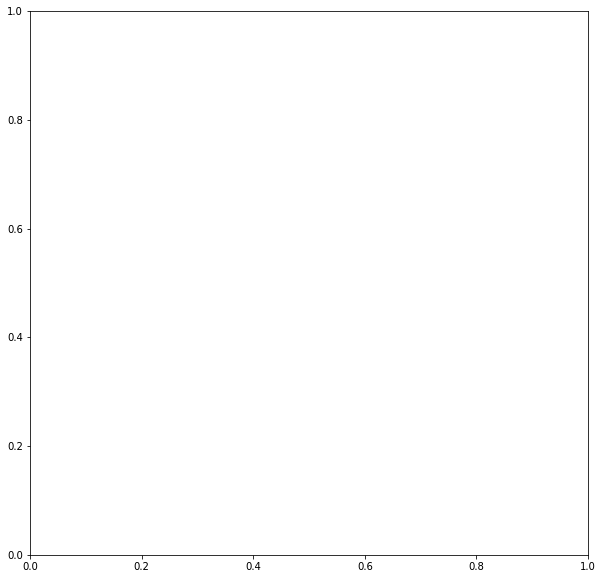

In [129]:
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(embedding_sim_tsne[:, 0], embedding_sim_tsne[:, 1], c=[sns.color_palette()[x] for x in grid_target_sim],s = 50)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Similar', fontsize=15);